Text(0.5,1,'Number of frames = 18725, Detector = NUV, Filter = F0          \nSource = NGC 188, OBS ID = T02_002T01_9000001914, Date = 2018-02-23')

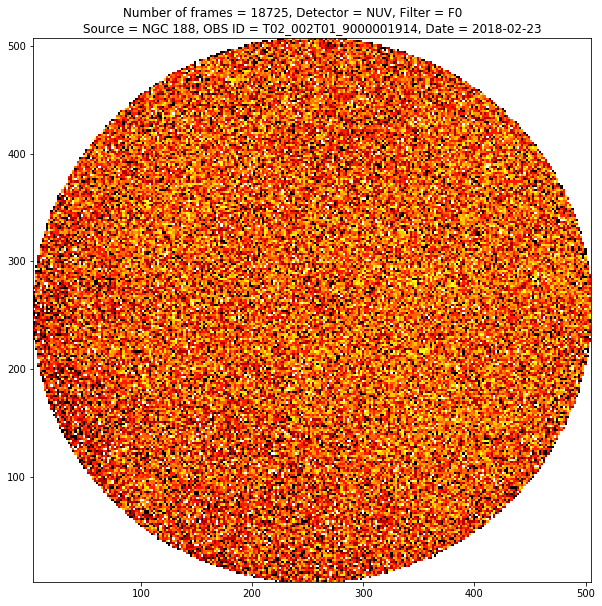

In [5]:
import sys
# import matplotlib
# Force matplotlib to not use any Xwindows backend.
# matplotlib.use('Agg')
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm


final_image_res = 256

L1_FITS = 'AS1T02_002T01_9000001914uvtNIIPC00F0_level1.fits.gz'
hdulist = fits.open(L1_FITS)

# The bloody thing was read as 8-bit integers (2016 columns).
droid_array = hdulist[2].data['Centroid']

# Unpacks elements of a 8-bit int array into a binary-valued output array.
# Now with 16128 columns.
bit_data = np.unpackbits(droid_array, axis =1)  

# Reshaping the array with only 3 words (48 bits) in the row.
len_row = len(bit_data) * 336
bit_dat = bit_data.reshape(len_row, 48)

# bit data gets converted to useful events data. Hold my beer! 
Rx = bit_dat[:, 0] * 256
Lx = np.packbits(bit_dat[:, 1:9])
Ix = Rx + Lx

Ry = bit_dat[:, 16] * 256
Ly = np.packbits(bit_dat[:, 17:25])
Iy = Ry + Ly

powers = np.array([32, 16,  8,  4,  2,  1], dtype=np.int8)

Fx = bit_dat[:, 9:15]
Fx = Fx.dot(powers)

Fy = bit_dat[:, 25:31]
Fy = Fy.dot(powers)

# To convert the 6-bit integers to subpixels.
substep = 0.03125

Fx[Fx > 31] = Fx[Fx > 31] - 64
Fx = Fx * substep

Fy[Fy > 31] = Fy[Fy > 31] - 64
Fy = Fy * substep

# Adding the integer and float parts together.
X_pos = Ix + Fx
Y_pos = Iy + Fy

# Keeping some standards.
X_p = X_pos[X_pos > 0.]
Y_p = Y_pos[X_pos > 0.]

# Making the image.
plt.figure(figsize = (10, 10))
plt.hist2d(X_p, Y_p, bins = final_image_res,
           norm =LogNorm(),
           cmap ='hot')

no_of_frames = len(bit_data)
detector = hdulist[0].header['detector']
filter_info = hdulist[0].header['filter']
date_obs = hdulist[0].header['date-obs']
source = hdulist[0].header['object']
obs_id = hdulist[0].header['obs_id']

plt.title('Number of frames = {}, Detector = {}, Filter = {}\
          \nSource = {}, OBS ID = {}, Date = {}'.\
          format(no_of_frames, detector, filter_info,
                 source, obs_id, date_obs))
